In [2]:
### Translation function: need to install niche translate package below for this to work
# pip install itranslate
from itranslate import itranslate as itrans
def translate(text_list):
    translations = {}
    for text in text_list:
        translations[text] = itrans(text, to_lang="en")
    return translations

In [3]:
import pyxlsb
import pandas as pd
import googlemaps

## To download datasets from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0135286#sec002
# wget wget https://doi.org/10.1371/journal.pone.0135286.s001 -O wuhan1.xlsb
# wget https://doi.org/10.1371/journal.pone.0135286.s002 -O wuhan2.xlsb

places = pd.read_excel("/home/alex/wuhan1.xlsb")
visits = pd.read_excel("/home/alex/wuhan2.xlsb")

places = places[~places.Name_POI.isna()]
visits = visits[~visits.Name_POI.isna()]

In [11]:
## Translate categories (takes ~1 min)
categories = places.Category.unique()
translated_categories = translate(categories)
places['Category_en'] = places.Category.map(translated_categories)

# How frequently visited is the Huanan Seafood Market?

In [59]:
## Get all markets visited at least 10 times
markets = places.query("Category_en == 'Convenience Store/Convenience Store' or Category_en == 'supermarket' or Category_en == 'shopping mall'")
highly_visited_markets = markets.query("`Checkin user number` >= 10")

## Translate their names
translated_markets = translate(highly_visited_markets['Name_POI'])
highly_visited_markets['Name_en'] = highly_visited_markets['Name_POI'].map(translated_markets)

## Huanan market
highly_visited_markets[highly_visited_markets.Name_en.str.contains("South China Seafood")]

/tmp/ipykernel_590766/1851374720.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highly_visited_markets['Name_en'] = highly_visited_markets['Name_POI'].map(translated_markets)


,Id_POI,Name_POI,Longitude,Latitude,Category,Checkin user number,Category_en,Name_en
1789,B2094655D46DA4F8439A,华南海鲜水产批发市场,114.26265,30.61709,便民商店/便利店,109,Convenience Store/Convenience Store,South China Seafood Fisheries Wholesale Market
8161,B2094655D46DA4FF459F,华南海鲜市场,114.26229,30.61660,便民商店/便利店,11,Convenience Store/Convenience Store,South China Seafood Market


In [67]:
## Fix the Huanan Seafood Market data by combining both entries above
highly_visited_markets.loc[highly_visited_markets.Name_en== 'South China Seafood Fisheries Wholesale Market','Checkin user number'] = 109+11

## Market figure

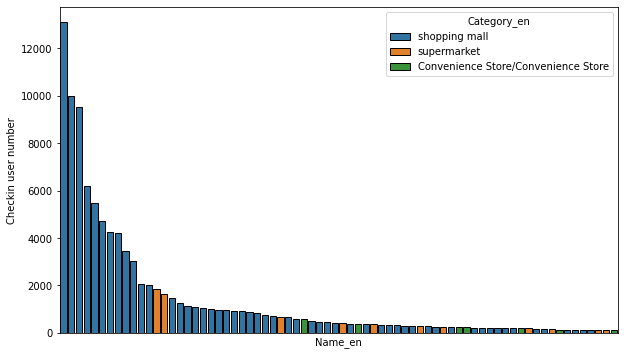

In [85]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,6)

sns.barplot(data = highly_visited_markets.query("`Checkin user number` >= 120"), 
            y='Checkin user number', hue='Category_en', x='Name_en', linewidth=1, 
            edgecolor="black", ci=None, dodge=False)
plt.xticks([])
plt.savefig("highly_visited_markets_final.svg")

## All locations figure

In [106]:
market_categories = ['Convenience Store/Convenience Store','supermarket','shopping mall']

school_categories = ['Middle school', 'College','Vocational and technical school','primary school']

religion_categories = ['church','Temple']

# List is from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7685932/table/tbl0001/

sse_categories = ['Residential area',
'College',
'Building',
'shopping mall',
'Hospital',
'Middle school',
'supermarket',
'bar',
'Convenience Store/Convenience Store',
'Sports place',
'Comprehensive Stadium',
'church',
'Temple',
'primary school']

other_categories = ['Residential area',
'Building',
'Hospital']

In [129]:
places2 = places.copy()
places2.loc[:,'Category_en'] = 'All'

markets1 = places[places.Category_en.isin(market_categories)]
markets1.loc[:,'Category_en'] = 'Markets'

sses1 = places[places.Category_en.isin(sse_categories)]
sses1.loc[:,'Category_en'] = 'High-risk SSE locations'

schools1 = places[places.Category_en.isin(school_categories)]
schools1.loc[:,'Category_en'] = 'Schools'

religion1 = places[places.Category_en.isin(school_categories)]
religion1.loc[:,'Category_en'] = 'Place of worship'

sports1 = places[places.Category_en.isin(school_categories)]
sports1.loc[:,'Category_en'] = 'Sports'

other = places[places.Category_en.isin(other_categories)]

places.loc[places.Name_POI== '华南海鲜水产批发市场','Checkin user number'] = 109+11
huanan = places[places.Name_POI== '华南海鲜水产批发市场']
huanan.loc[:,'Category_en'] = 'Huanan Seafood Market'

final = pd.concat([places2, sses1,markets1,schools1,other,huanan])

In [108]:
final['greater_than'] = 'smaller'
final.loc[final['Checkin user number'] > 120,'greater_than'] = 'larger'

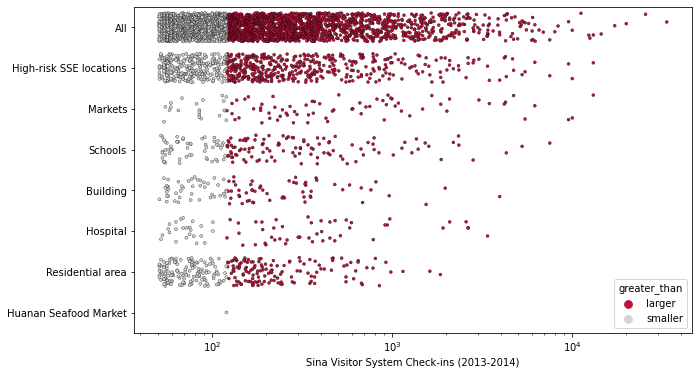

In [109]:
sns.stripplot(data=final.query("`Checkin user number`>50"), y='Category_en', 
              x='Checkin user number', s=3, hue='greater_than',jitter=0.35, linewidth=0.3,
             edgecolor='black', palette=['#b8143a','#d4d4d4',])
plt.xscale("log")
plt.xlabel("Sina Visitor System Check-ins (2013-2014)")
plt.ylabel("")
plt.savefig("sses_final.svg")

In [ ]:
final.groupby("Category_en").greater_than.value_counts()

Category_en              greater_than
All                      smaller         171433
                         larger            1676
Building                 smaller            559
                         larger              56
High-risk SSE locations  smaller          22259
                         larger             430
Hospital                 smaller           3752
                         larger              47
Huanan Seafood Market    smaller              1
Markets                  smaller           9707
                         larger              70
Residential area         smaller           6655
                         larger             136
Schools                  smaller           1392
                         larger             108
Name: greater_than, dtype: int64

In [125]:
places[places.Category_en.isin(sse_categories)].query("`Checkin user number`>120").to_csv("SSE_places.csv", index=None)
places.query("`Checkin user number`>120").to_csv("all_places.csv", index=None)

# Probability calculations (by visitor number)

In [87]:
huanan_visitors = int(places[places.Name_POI== '华南海鲜水产批发市场']['Checkin user number'])

market_visitors = markets1.query('`Checkin user number` > 120')['Checkin user number'].sum()
sse_visitors = sses1.query('`Checkin user number` > 120')['Checkin user number'].sum()

print("{} visitors to HSM ".format(huanan_visitors))
print("{} visitors to all markets with more visitors than HSM".format(market_visitors))
print("{} visitors to all high-risk SSE locations".format(sse_visitors))

print(huanan_visitors / market_visitors)
print(huanan_visitors / sse_visitors)

120 visitors to HSM 
98146 visitors to all markets with more visitors than HSM
262233 visitors to all high-risk SSE locations
0.0012226682697206203
0.00045760831016691263


### Other live-animal markets

In [92]:
baishazhou_visitors = int(places[places.Name_POI== '武汉白沙洲农产品大市场']['Checkin user number'])
qiyimen_visitors = int(places[places.Name_POI== '起义门生鲜市场']['Checkin user number'])
dijao_visitors = int(places[places.Name_POI== '堤角花鸟宠物大世界']['Checkin user number'])


In [93]:
print("{} visitors to Baishazhou".format(baishazhou_visitors))
print("{} visitors to Qiyimen".format(qiyimen_visitors))
print("{} visitors to Dijao".format(dijao_visitors))

82 visitors to Baishazhou
0 visitors to Qiyimen
4 visitors to Dijao
